In [2]:
from matplotlib import pyplot as plt

In [3]:
import netcomp as nc

# use if making graphics for a presentation
plt.style.use(['classic','ggplot'])

figures_dir = '/Users/peterwills/google-drive/Research/Graph Distance Study/metrics_paper/figures'

We're looking at the [primary school temporal network dataset](http://www.sociopatterns.org/datasets/primary-school-temporal-network-data/).

This notebook is for the analysis used in the dynamic SBM paper. It considers the graph as a dynamic object, and looks at distances between timesteps.

# Get data from web

In [4]:
%%bash
cd data
curl -O http://snap.stanford.edu/data/CollegeMsg.txt.gz
gunzip CollegeMsg.txt.gz

# grab metadata too

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  337k  100  337k    0     0   217k      0  0:00:01  0:00:01 --:--:--  217k


In [7]:
ls ./data

CollegeMsg.txt              metadata_primaryschool.txt
abide_connectivity.mat      primaryschool.csv


# Load in data

We have a bunch of time-stamped edges in a csv. We need to turn these into a sequence of graphs so that we can look at the resistance distance between timesteps. Let's see how this does.

In [9]:
import pandas as pd

In [11]:
import os
os.getcwd()

'/Users/peterwills/code/python/graph_metrics_paper_code'

In [13]:
full_data = pd.read_csv('./data/CollegeMsg.txt',sep=' ',header=None)

In [14]:
full_data.head()

,0,1,2
0,1,2,1082040961
1,3,4,1082155839
2,5,2,1082414391
3,6,7,1082439619
4,8,7,1082439756


In [15]:
full_data.columns = ['i','j','ts']

In [17]:
from datetime import datetime

In [20]:
full_data['dt'] = full_data['ts'].apply(datetime.fromtimestamp)

In [24]:
full_data['day'] = full_data['dt'].apply(lambda x: x.date())

Text(0.5, 1.0, 'message volume by day')

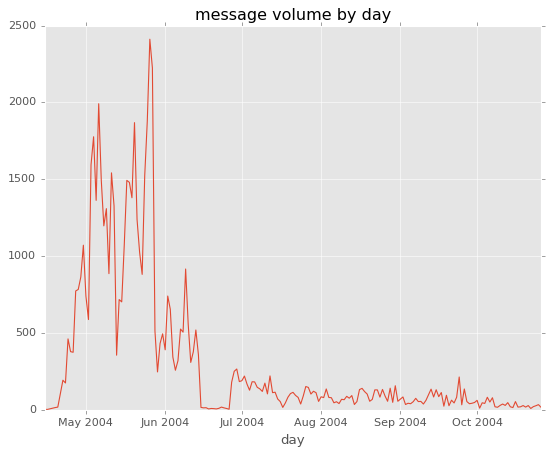

In [28]:
full_data.groupby('day').count()['ts'].plot()
plt.title('message volume by day')

In [30]:
import networkx as nx

In [56]:
graphs = []
amats = []
amats_clean = []
days = []

all_ids = list(full_data['i']) + list(full_data['j'])

for day, df in full_data.groupby('day'):
    days.append(day)
    G = nx.Graph()
    G.add_nodes_from(all_ids)
    G.add_edges_from(zip(df['i'],df['j']))
    graphs.append(G)
    amats.append(nx.adjacency_matrix(G))
    G.remove_nodes_from(nx.isolates(G))
    amats_clean.append(nx.adjacency_matrix(G))

days = days[1:]

# Analysis

Let's take the renormalized resistance distance between each graph, along with the edit distance, and see what we can see.

In [47]:
def vol_dist(A1,A2):
    """Volume difference between two graphs."""
    return np.abs(A1.sum() - A2.sum())/2

In [48]:
import numpy as np

In [50]:
from tqdm import tqdm

In [53]:
len(amats) * 6.5 / 60

20.908333333333335

In [54]:
%%time

r_dists = []
e_dists = []
d_dists = []
ns_dists = []
adj_dists = []
lap_dists = []
nlap_dists = []
vol_dists = []

for A_old,A in tqdm(zip(amats[:-1],amats[1:])):
    r_dists.append(nc.resistance_distance(A,A_old,renormalized=True))
    e_dists.append(nc.edit_distance(A,A_old))
    d_dists.append(nc.deltacon0(A,A_old))
    ns_dists.append(nc.netsimile(A,A_old))
    adj_dists.append(nc.lambda_dist(A,A_old,kind='adjacency'))
    lap_dists.append(nc.lambda_dist(A,A_old,kind='laplacian'))
    nlap_dists.append(nc.lambda_dist(A,A_old,kind='laplacian_norm'))
    vol_dists.append(vol_dist(A,A_old))


0it [00:00, ?it/s]
1it [00:06,  6.43s/it]
2it [00:12,  6.45s/it]
3it [00:19,  6.58s/it]
4it [00:26,  6.56s/it]
5it [00:33,  6.65s/it]
6it [00:40,  6.77s/it]
7it [00:47,  6.85s/it]
8it [00:54,  6.94s/it]
9it [01:01,  6.99s/it]
10it [01:08,  7.05s/it]
11it [01:15,  7.05s/it]
12it [01:22,  7.03s/it]
13it [01:30,  7.10s/it]
14it [01:37,  7.08s/it]
15it [01:44,  7.04s/it]
16it [01:51,  7.06s/it]
17it [01:58,  7.14s/it]
18it [02:05,  7.19s/it]
19it [02:13,  7.26s/it]
20it [02:20,  7.35s/it]
21it [02:28,  7.44s/it]
22it [02:36,  7.56s/it]
23it [02:43,  7.46s/it]
24it [02:50,  7.44s/it]
25it [02:58,  7.44s/it]
26it [03:05,  7.37s/it]
27it [03:12,  7.28s/it]
28it [03:19,  7.28s/it]
29it [03:26,  7.24s/it]
30it [03:34,  7.29s/it]
31it [03:41,  7.37s/it]
32it [03:49,  7.47s/it]
33it [03:57,  7.50s/it]
34it [04:04,  7.51s/it]
35it [04:12,  7.46s/it]
36it [04:19,  7.44s/it]
37it [04:27,  7.50s/it]
38it [04:35,  7.70s/it]
39it [04:43,  7.74s/it]
40it [04:51,  7.88s/it]
41it [04:59,  7.87s/it]
42it 

CPU times: user 45min 17s, sys: 3min 44s, total: 49min 2s
Wall time: 22min 39s


In [55]:
# normalize by sample mean
r_dists = r_dists/np.mean(r_dists)
e_dists = e_dists/np.mean(e_dists)
d_dists = d_dists/np.mean(d_dists)
ns_dists = ns_dists/np.mean(ns_dists)
adj_dists = adj_dists/np.mean(adj_dists)
lap_dists = lap_dists/np.mean(lap_dists)
nlap_dists = nlap_dists/np.mean(nlap_dists)
vol_dists = vol_dists/np.mean(vol_dists)

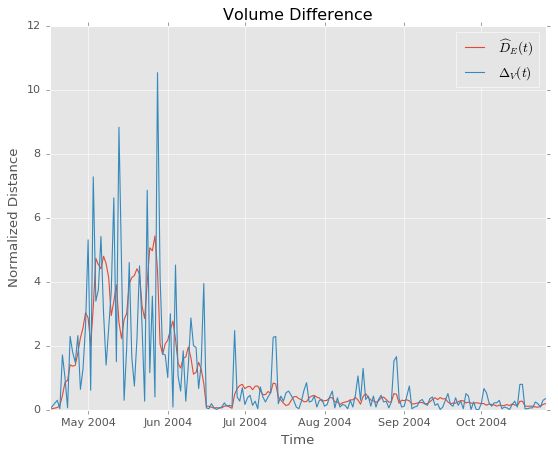

In [57]:
# plot curves
plt.plot(days,e_dists,label='$\widehat{D}_E(t)$');
plt.plot(days,vol_dists,label='$\Delta_V(t)$');
plt.xlabel('Time');
plt.ylabel('Normalized Distance');
plt.title('Volume Difference');
plt.legend();

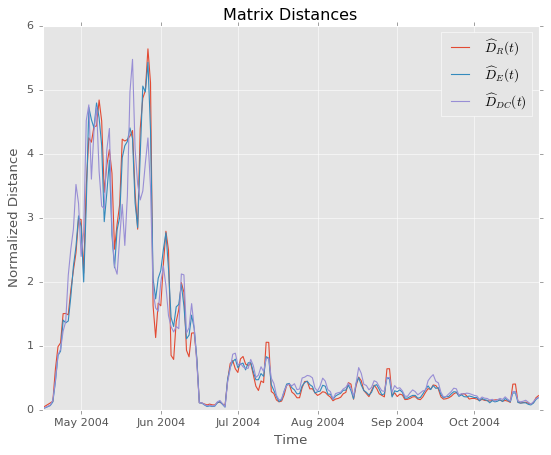

In [58]:

# plot curves
plt.plot(days,r_dists,label='$\widehat{D}_R(t)$');
plt.plot(days,e_dists,label='$\widehat{D}_E(t)$');
plt.plot(days,d_dists,label='$\widehat{D}_{DC}(t)$');

plt.xlabel('Time');
plt.ylabel('Normalized Distance');
plt.title('Matrix Distances');
plt.legend();

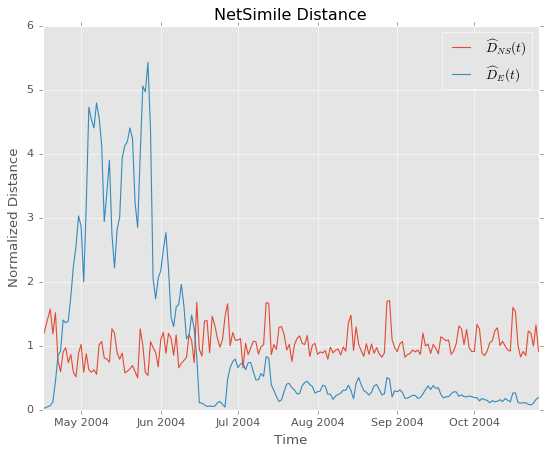

In [59]:
# plot curves
plt.plot(days,ns_dists,label='$\widehat{D}_{NS}(t)$');
plt.plot(days,e_dists,label='$\widehat{D}_E(t)$');


plt.xlabel('Time');
plt.ylabel('Normalized Distance');
plt.title('NetSimile Distance');
plt.legend(loc='upper left');
plt.legend();

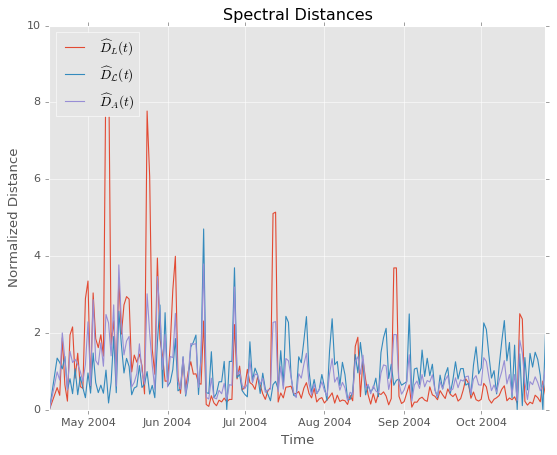

In [60]:

# plot curves
plt.plot(days,lap_dists,label='$\widehat{D}_{L}(t)$');
plt.plot(days,nlap_dists,label='$\widehat{D}_{\mathcal{L}}(t)$');
plt.plot(days,adj_dists,label='$\widehat{D}_{A}(t)$');

# axes labels & title
plt.xlabel('Time');
plt.ylabel('Normalized Distance');
plt.title('Spectral Distances');
plt.legend(loc='upper left');